# Deep Learning HAM10000 classification

# Table of contents

* [Python libraries](#libraries)
* [Import of the Data and Images](#importing_Data)
* [Metadata Pre-processing](#metadata)
* [Image Pre-processing ](#images)
* [Initial model without skin hair remove funtion](#skinhair)
* [Initial Model with skin hair remove funtion](#noskinhair)
* [Keras tunner Random Search](#kerastunner)
* [Pre trained Model DenseNet121](#pretrained)
* [Test data Set](#testdata)
* [Predicting Test with DenseNet121](#predicttest)
* [Predicting test with the final model](#predicttestfinal)


<a id = 'libraries' ></a>
# Python libraries

In [ ]:
#!pip install opencv-python


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from kerastuner.tuners import RandomSearch
import kerastuner as kt
from tensorflow.keras.applications import *
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
import cv2
import os

C:\Users\filip\AppData\Local\Temp\ipykernel_12412\1656426164.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


<a id = 'importing_data' ></a>

# Import of the Data and Images

In [4]:

#df = pd.read_csv('/Users/hugobarata/Desktop/ProjectDL23_24/HAM10000_metadata.csv'
df = pd.read_csv('C:/Users/filip/OneDrive/Ambiente de Trabalho/escola/Deep Learning/ProjectDL23_24/HAM10000_metadata.csv')


In [5]:
#Directory 
image_dir = 'C:\\Users\\filip\\OneDrive\\Ambiente de Trabalho\\escola\\Deep Learning\\ProjectDL23_24\\train'
#image_dir = '/Users/hugobarata/Desktop/ProjectDL23_24/train'
#Adding path of images to metadata
df['path'] = df['image_id'].apply(lambda image_id: os.path.join(image_dir, f'{image_id}.jpg'))
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...


<a id = 'metadata' ></a>
# Meta data Pre-processing and visualization

In [4]:
#Check for missing values
missing = df.isnull().sum()
print(missing)

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
dtype: int64


In [6]:
#See ages=0 
invalid_age = df[df['age'] <= 0]

# Print the number of rows with age <= 0
print(f"Number of rows with age <= 0: {len(invalid_age)}")

Number of rows with age <= 0: 39


In [7]:
#Replacing age=0 and non existing values with the median
df['age'] = df['age'].replace(0, np.nan)

median_age = df['age'].median()
df['age'].fillna(median_age, inplace=True)

In [8]:
invalid_age = df[df['age'] <= 0]
# Print  age <= 0
print(f"Number of rows with age <= 0: {len(invalid_age)}")

Number of rows with age <= 0: 0


In [9]:
#See the uptaded missing values
missing_values_after = df.isnull().sum()
print(missing_values_after )

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
dtype: int64


In [9]:
df.count()

lesion_id       10015
image_id        10015
dx              10015
dx_type         10015
age             10015
sex             10015
localization    10015
path            10015
dtype: int64

In [12]:
#check if the image  exists in he directory
def image_exists(image_id):
    image_path = os.path.join(image_dir, image_id + '.jpg')
    return os.path.exists(image_path)

df = df[df['image_id'].apply(image_exists)]



In [13]:
df.count()

lesion_id         7511
image_id          7511
dx                7511
dx_type           7511
age               7511
sex               7511
localization      7511
path              7511
numeric_labels    7511
dtype: int64

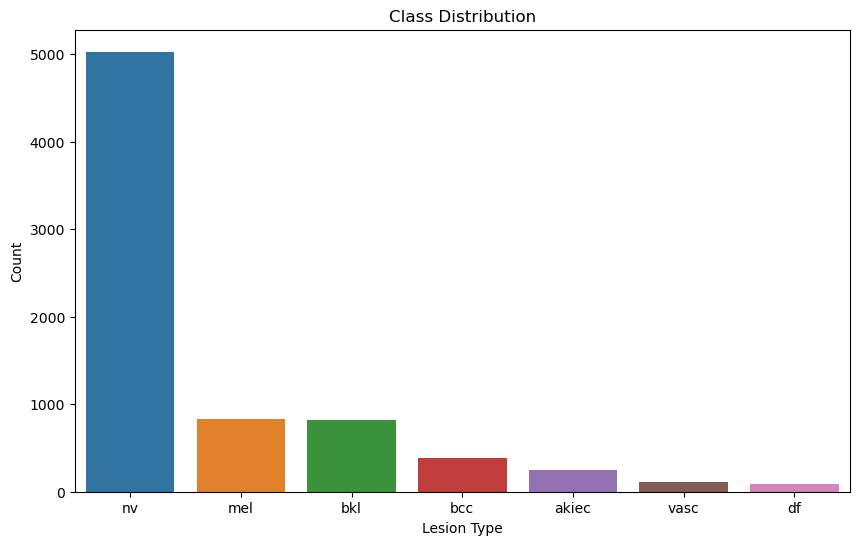

In [12]:
#Plotting the labels distribution
distribution = df['dx'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='dx', data=df, order=distribution.index)
plt.title('Class Distribution')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()



In [13]:
#Number of nv in data
count_nv = df['dx'].str.count('nv').sum()
print(count_nv)

5029


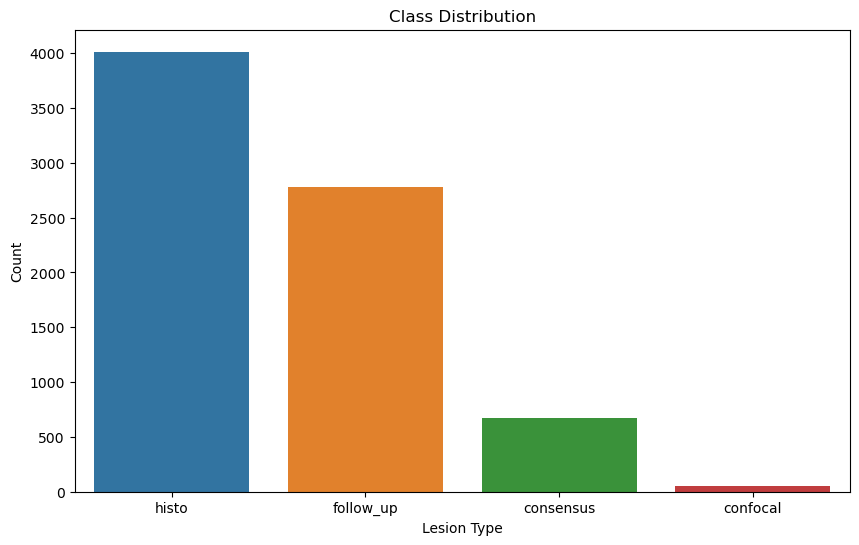

In [14]:
#distribution of dx_type
class_distribution = df['dx_type'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='dx_type', data=df, order=class_distribution.index)
plt.title('Class Distribution')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()

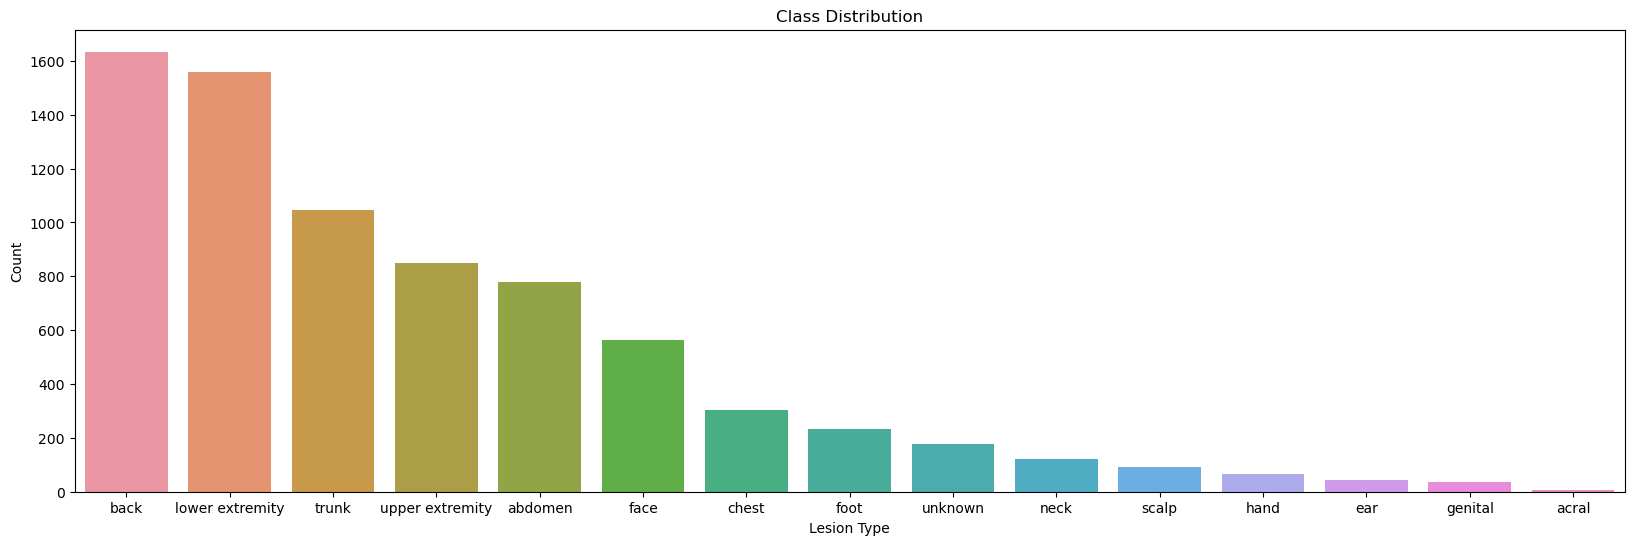

In [15]:
class_distribution = df['localization'].value_counts()

plt.figure(figsize=(20, 6))
sns.countplot(x='localization', data=df, order=class_distribution.index)
plt.title('Class Distribution')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()

In [16]:
count_unknown = df['localization'].str.count('unknown').sum()


print("Number of occurrences of 'unknown' in the 'localization' column:", count_unknown)

Number of occurrences of 'unknown' in the 'localization' column: 179


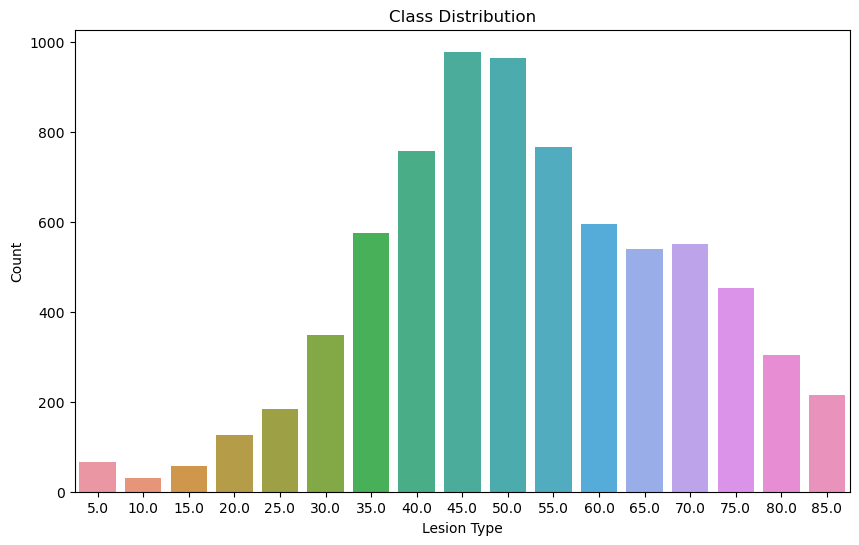

In [17]:


# Displaying Age distribution
class_distribution = df['age'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='age', data=df, order=class_distribution.index.sort_values())
plt.title('Class Distribution')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()


In [18]:
max_age = df['age'].max()
min_age = df['age'].min()


print("Maximum age:", max_age)
print("Minimum age:", min_age)

Maximum age: 85.0
Minimum age: 5.0


In [21]:
df.count()

lesion_id             7511
image_id              7511
dx                    7511
dx_type               7511
age                   7511
sex                   7511
localization          7511
path                  7511
numeric_labels        7511
image                 7511
hair_removed_image    7511
dtype: int64

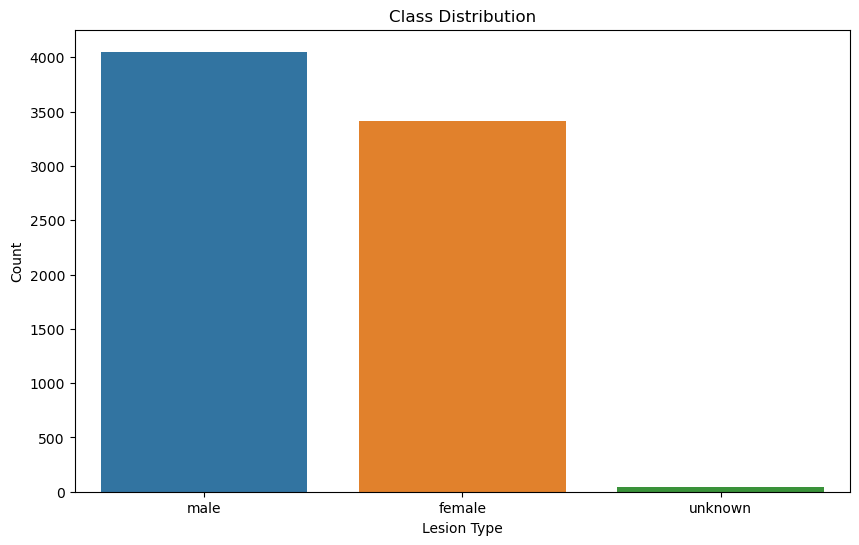

In [20]:
class_distribution = df['sex'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='sex', data=df, order=class_distribution.index)
plt.title('Class Distribution')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()

In [21]:
count_unknown_sex = df['sex'].str.count('unknown').sum()


print("Number of occurrences of 'unknown' in the 'sex' column:", count_unknown_sex)

Number of occurrences of 'unknown' in the 'sex' column: 44


In [22]:
# Making dummies on categorical variables
df = pd.get_dummies(df, columns=['dx_type'], prefix='dx_type')
df = pd.get_dummies(df, columns=['sex'], prefix='sex')
df = pd.get_dummies(df, columns=['localization'], prefix='localization')

In [23]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
df['age_normalized'] = scaler.fit_transform(df['age'].values.reshape(-1, 1))


In [24]:
df.head(5)

,lesion_id,image_id,dx,age,path,dx_type_confocal,dx_type_consensus,dx_type_follow_up,dx_type_histo,sex_female,...,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,age_normalized
0,HAM_0000118,ISIC_0027419,bkl,80.0,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,0.9375
1,HAM_0000118,ISIC_0025030,bkl,80.0,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,0.9375
2,HAM_0002730,ISIC_0026769,bkl,80.0,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,0.9375
3,HAM_0002730,ISIC_0025661,bkl,80.0,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,0.9375
4,HAM_0001466,ISIC_0031633,bkl,75.0,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0.8750


In [26]:

df['image_dimensions'] = df['path'].map(lambda x: np.asarray(Image.open(x).size)).apply(lambda x: f"{x[0]}x{x[1]}")

# Find the smallest and largest image dimensions
min_dimensions = df['image_dimensions'].min()
max_dimensions = df['image_dimensions'].max()

# Display the results
print(f"Smallest Image Dimensions: ({min_dimensions})")
print(f"Largest Image Dimensions: ({max_dimensions})")





Smallest Image Dimensions: (600x450)
Largest Image Dimensions: (600x450)


In [34]:
#Making Labels variable for classification 
label_encoder = LabelEncoder()
df['numeric_labels'] = label_encoder.fit_transform(df['dx'])

# One-hot encode the numeric labels
labels = to_categorical(df['numeric_labels'])

<a id = 'images' ></a>

# Image Pre-processing 

In [14]:
# Importing images from directory and rezise it to 256,256
df["image"]=df['path'].map(lambda x: np.asarray(Image.open(x).resize((256,256))))


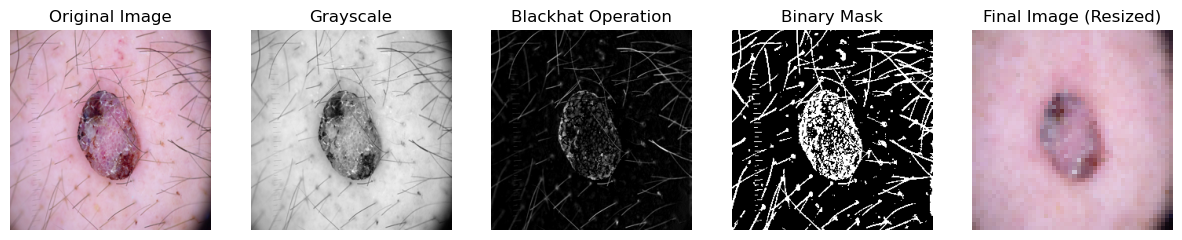

In [29]:
df["image1"]=df["image"]
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image_transformations(image):
    # Convert image to NumPy
    image_np = np.array(image, dtype=np.uint8)
    # Convert to grayscale
    gray_scale = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    # Define the kernel for morphological operations
    kernel = cv2.getStructuringElement(1, (10, 10))
    # Apply morphological blackhat operation
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)
   # Apply thresholding to create a binary mask
    ret, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    # Inpaint the original image using the binary mask
    final_image = cv2.inpaint(image_np, threshold, 5, cv2.INPAINT_TELEA)
    final_image = cv2.resize(final_image, (50, 50))
    # Plot all intermediate images
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    axs[0].imshow(image_np)
    axs[0].axis('off')
    axs[0].set_title("Original Image")

    axs[1].imshow(gray_scale, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Grayscale")

    axs[2].imshow(blackhat, cmap='gray')
    axs[2].axis('off')
    axs[2].set_title("Blackhat Operation")

    axs[3].imshow(threshold, cmap='gray')
    axs[3].axis('off')
    axs[3].set_title("Binary Mask")

    axs[4].imshow(final_image)
    axs[4].axis('off')
    axs[4].set_title("Final Image (Resized)")

    plt.show()

# Example:
example_image = df['image1'].iloc[16]
display_image_transformations(example_image)


In [18]:
# Removing Hair sking from the images for better viewing and resizing to 50,50
def remove_hair(image):
    # Convert  image  to  NumPy
    image_np = np.array(image, dtype=np.uint8)
    # Convert  to grayscale
    gray_scale = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    # Define the kernel for morphological operations
    kernel = cv2.getStructuringElement(1, (10, 10))
    # Apply morphological blackhat operation
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)
    # Apply thresholding to create a binary mask
    ret, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    # Inpaint the original image using the binary mask
    final_image = cv2.inpaint(image_np, threshold, 5, cv2.INPAINT_TELEA)
    final_image = cv2.resize(final_image, (50, 50))

    return final_image

# Applying funtion to images
df['hair_removed_image'] = df['image'].apply(remove_hair)


<a id = 'skinhair' ></a>

# Trying Initial model without  skin hair remove funtion

In [31]:
df['image'] = df['image'].apply(lambda x: np.asarray(Image.fromarray(x).resize((50, 50))))
#Pass to list
images = np.array(df['image'].tolist()) 

# Convert to a NumPy array
images = np.array(images)

# Normalizing 
images = images / 255.0
#train test split
train_images, val_images, train_labels, val_labels = train_test_split(images, labels,stratify=labels,
                                                                      test_size=0.2, random_state=42)


#Transform with image data generator in trainning and validation (only fit in val)
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation in the range [-20, 20] degrees//
    width_shift_range=0.2,   # Random horizontal shift by up to 20% of the width
    height_shift_range=0.2,  # Random vertical shift by up to 20% of the height
    shear_range=0.2,         # Shear intensity
    zoom_range=0.2,          # Random zoom by up to 20%
    horizontal_flip=True,    # Random horizontal flip
    vertical_flip=True       # Random vertical flip
)


train_generator = datagen.flow(train_images, train_labels, batch_size=32)
datagen = ImageDataGenerator()
val_generator = datagen.flow(val_images, val_labels, batch_size=32)


In [32]:
# Define input shape
input_shape = (50,50, 3)  # Adjust the size based on your requirements

# Define the model
model_1 = Sequential()

# 3 Convolutional layers
model_1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_1.add(MaxPooling2D(2, 2))
model_1.add(Conv2D(64, 3, activation='relu'))
model_1.add(MaxPooling2D(2, 2))
model_1.add(Conv2D(128, 3, activation='relu'))
model_1.add(MaxPooling2D(2, 2))


model_1.add(Flatten())


#1 Dense layers with 512 units and 0.5 dropout
model_1.add(Dropout(0.5))
model_1.add(Dense(512, activation='relu'))
model_1.add(Dense(7, activation='softmax'))

# Compile the model
model_1.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_1.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)       

In [40]:
#fitting the model
history1 = model_1.fit(train_generator, epochs=50, validation_data=val_generator)

# Evaluate the model 
val_loss, val_acc = model_1.evaluate(val_images, val_labels)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

Epoch 1/50
188/188 [==============================] - 9s 49ms/step - loss: 0.6191 - accuracy: 0.7598 - val_loss: 0.6968 - val_accuracy: 0.7252
Epoch 2/50
188/188 [==============================] - 10s 55ms/step - loss: 0.6313 - accuracy: 0.7645 - val_loss: 0.6619 - val_accuracy: 0.7478
Epoch 3/50
188/188 [==============================] - 10s 53ms/step - loss: 0.6241 - accuracy: 0.7676 - val_loss: 0.6654 - val_accuracy: 0.7505
Epoch 4/50
188/188 [==============================] - 8s 43ms/step - loss: 0.6185 - accuracy: 0.7663 - val_loss: 0.6448 - val_accuracy: 0.7625
Epoch 5/50
188/188 [==============================] - 8s 43ms/step - loss: 0.6239 - accuracy: 0.7631 - val_loss: 0.6372 - val_accuracy: 0.7598
Epoch 6/50
188/188 [==============================] - 9s 46ms/step - loss: 0.6232 - accuracy: 0.7651 - val_loss: 0.6512 - val_accuracy: 0.7518
Epoch 7/50
188/188 [==============================] - 9s 47ms/step - loss: 0.6190 - accuracy: 0.7698 - val_loss: 0.6931 - val_accuracy: 0.72

In [41]:
# Calculate F1 score
  
val_predictions = model_1.predict(val_images)
val_predictions_class = np.argmax(val_predictions, axis=1)
val_labels_class = np.argmax(val_labels, axis=1)

f1_weighted = f1_score(val_labels_class, val_predictions_class, average='weighted')
f1_macro = f1_score(val_labels_class, val_predictions_class, average='macro')

print(f'Weighted F1 Score: {f1_weighted}')
print(f'Macro F1 Score: {f1_macro}')

47/47 [==============================] - 0s 9ms/step
Weighted F1 Score: 0.7417175293687915
Macro F1 Score: 0.5302074235244987


<a id = 'noskinhair' ></a>

# Trying Initial Model with skin hair removed funtion

Pre processed images modeling

In [22]:
#Treating Hair removed images
hair_removed_images = np.array(df['hair_removed_image'].tolist())  
hair_removed_images = np.array(hair_removed_images)
hair_removed_images = hair_removed_images / 255.0

In [35]:
# Splitting the data with stratify 
train_images_shr, val_images_shr, train_labels_shr, val_labels_shr = train_test_split(hair_removed_images, labels, test_size=0.2,stratify=labels, random_state=42)


In [36]:

datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation in the range [-20, 20] degrees
    width_shift_range=0.2,   # Random horizontal shift by up to 20% of the width
    height_shift_range=0.2,  # Random vertical shift by up to 20% of the height
    shear_range=0.2,         # Shear intensity
    zoom_range=0.2,          # Random zoom by up to 20%
    horizontal_flip=True,    # Random horizontal flip
    vertical_flip=True       # Random vertical flip
)

# Create a generator for training data with data augmentation and val just fit
train_generator = datagen.flow(train_images_shr, train_labels_shr, batch_size=32)
datagen = ImageDataGenerator()
val_generator = datagen.flow(val_images_shr, val_labels_shr, batch_size=32)


Fitting the model 

In [45]:
# Define the same initial model
model_2 = Sequential()

# 3 Convolutional layers
model_2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_2.add(MaxPooling2D(2, 2))
model_2.add(Conv2D(64, 3, activation='relu'))
model_2.add(MaxPooling2D(2, 2))
model_2.add(Conv2D(128, 3, activation='relu'))
model_2.add(MaxPooling2D(2, 2))

# Flatten layer
model_2.add(Flatten())

# Dense layers
model_2.add(Dropout(0.5))
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(7, activation='softmax'))

# Compile the model
model_2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model_2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 4, 128)        

Evaluating the model

In [46]:
history2 = model_2.fit(train_generator, epochs=50, validation_data=(val_generator))

# Evaluate the model on the validation set
val_loss, val_acc = model_2.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

Epoch 1/50
188/188 [==============================] - 11s 50ms/step - loss: 1.0382 - accuracy: 0.6663 - val_loss: 0.9586 - val_accuracy: 0.6693
Epoch 2/50
188/188 [==============================] - 9s 46ms/step - loss: 0.9815 - accuracy: 0.6676 - val_loss: 0.9698 - val_accuracy: 0.6693
Epoch 3/50
188/188 [==============================] - 9s 48ms/step - loss: 0.9322 - accuracy: 0.6703 - val_loss: 0.9353 - val_accuracy: 0.6613
Epoch 4/50
188/188 [==============================] - 9s 48ms/step - loss: 0.9058 - accuracy: 0.6733 - val_loss: 0.8772 - val_accuracy: 0.6687
Epoch 5/50
188/188 [==============================] - 9s 48ms/step - loss: 0.8820 - accuracy: 0.6788 - val_loss: 0.8887 - val_accuracy: 0.6673
Epoch 6/50
188/188 [==============================] - 9s 47ms/step - loss: 0.8815 - accuracy: 0.6859 - val_loss: 0.8800 - val_accuracy: 0.6653
Epoch 7/50
188/188 [==============================] - 9s 48ms/step - loss: 0.8496 - accuracy: 0.6912 - val_loss: 0.8354 - val_accuracy: 0.679

NameError: name 'val_generator_shr' is not defined

In [48]:
val_loss, val_acc = model_2.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

47/47 [==============================] - 0s 9ms/step - loss: 0.6504 - accuracy: 0.7591
Validation Loss: 0.6504268646240234, Validation Accuracy: 0.759148359298706


In [49]:
 # Calculate F1 score
val_predictions = model_2.predict(val_images_shr)
val_predictions_class = np.argmax(val_predictions, axis=1)
val_labels_class = np.argmax(val_labels_shr, axis=1)


f1_weighted = f1_score(val_labels_class, val_predictions_class, average='weighted')
f1_macro = f1_score(val_labels_class, val_predictions_class, average='macro')

print(f'Weighted F1 Score: {f1_weighted}')
print(f'Macro F1 Score: {f1_macro}')

47/47 [==============================] - 0s 9ms/step
Weighted F1 Score: 0.7473232391088142
Macro F1 Score: 0.5289066720965717


<a id = 'kerastunner' ></a>

# Keras tunner Random Search

with 4 convolutional layers

In [ ]:
# Define a function to build the model with hyperparameters
def build_model(hp):
    model = Sequential()

    # 4 Convolutional layers with different units
    model.add(Conv2D(hp.Int('conv1_units', min_value=16, max_value=64, step=16), 3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=64, step=64), 3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(hp.Int('conv3_units', min_value=32, max_value=128, step=64), 3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(hp.Int('conv4_units', min_value=32, max_value=256, step=64), 3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    # Flatten layer
    model.add(Flatten())

    # Dense layers with different units and dropout betwenn 0.3 and 0.6
    model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu'))
    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Use random Search to look for the best model
#tuner = RandomSearch(
#    build_model,
#    objective='val_accuracy',
#    max_trials=20, 
#    directory='keras_tuner_with_443_layerr',
#    project_name='cnn_tuning_with_443_layerr'
#)

# Found the best model
#tuner.search(train_generator, epochs=50, validation_data=val_generator)

# Get the best hyperparameters
#best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best model
#print("Best Model:")
#print(best_hps.values)

# Using the best model to fit the data
#best_model = tuner.hypermodel.build(best_hps)

# Display the summary of the best model
#best_model.summary()

# Train the model
#history = best_model.fit(train_generator, epochs=50, validation_data=val_generator)

OUTPUT OF RANDOM SEARCH:

 
 Trial 20 Complete [00h 06m 55s]
val_accuracy: 0.7604790329933167

Best val_accuracy So Far: 0.7697937488555908
Total elapsed time: 02h 20m 54s
Best Model:
{'conv1_units': 32, 'conv2_units': 32, 'conv3_units': 96, 'conv4_units': 160, 'dropout': 0.3, 'dense_units': 512}
Model: "sequential_1"

In [ ]:
# The accuracies  of all models with 3 layers
#for trial in tuner.oracle.get_best_trials(num_trials=20):
  # print(trial.hyperparameters.values)
   # print("Validation Accuracy:", trial.score)
   # print("_______________________________________________________________________________________-" )


In [ ]:
#Model:
#{'conv1_units': 32, 'conv2_units': 32, 'conv3_units': 96, 'conv4_units': 160, 'dropout': 0.3, 'dense_units': 512}
#Validation Accuracy: 0.7697937488555908
#_______________________________________________________________________________________-
#Model:
#{'conv1_units': 48, 'conv2_units': 32, 'conv3_units': 96, 'conv4_units': 160, 'dropout': 0.5, 'dense_units': 320}
#Validation Accuracy: 0.7631403803825378
#_______________________________________________________________________________________-
#Model:
#{'conv1_units': 32, 'conv2_units': 32, 'conv3_units': 96, 'conv4_units': 96, 'dropout': 0.3, 'dense_units': 256}
#Validation Accuracy: 0.7604790329933167
#_______________________________________________________________________________________-
#Model:
#{'conv1_units': 16, 'conv2_units': 32, 'conv3_units': 96, 'conv4_units': 32, 'dropout': 0.3, 'dense_units': 256}
#Validation Accuracy: 0.7571523785591125
#_______________________________________________________________________________________-
#Model:
#{'conv1_units': 16, 'conv2_units': 32, 'conv3_units': 96, 'conv4_units': 224, 'dropout': 0.5, 'dense_units': 320}
#Validation Accuracy: 0.7571523785591125
#_______________________________________________________________________________________-


with 3 convolutional layers

In [99]:
def build_model(hp):
    model = Sequential()

    # Convolutional layers with only 2 max pooling layers 
    model.add(Conv2D(hp.Int('conv1_units', min_value=8, max_value=64, step=8), 3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))  
    model.add(Conv2D(hp.Int('conv2_units', min_value=16, max_value=128, step=16), 3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(hp.Int('conv3_units', min_value=32, max_value=256, step=32), 3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
   # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.6, step=0.1)))
    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Use random search
#tuner = RandomSearch(
#    build_model,
#    objective='val_accuracy',
#    max_trials=20,  # Adjust the number of trials as needed
#    directory='keras_tuner_final_33layer22',
#    project_name='cnn_tuning_final33_layer22')
#)

# Search for the best model
#tuner.search(train_generator, epochs=50, validation_data=val_generator)

# Get the best model
#best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best model
#print("Best Model:")
#print(best_hps.values)

# Build the best model 
#best_model = tuner.hypermodel.build(best_hps)
#best_model.summary()

# Train the model 
#history = best_model.fit(train_generator, epochs=50, validation_data=val_generator)/

Output of Random Search:
Trial 20 Complete [00h 13m 31s]
val_accuracy: 0.7598137259483337

Best val_accuracy So Far: 0.7664670944213867
Total elapsed time: 01h 31m 53s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
8                 |16                |conv1_units
80                |112               |conv2_units
224               |256               |conv3_units
128               |256               |dense_units
0.2               |0.2               |dropout


In [95]:
# The accuracies of all models with 3 convolutional layers  
for trial in tuner.oracle.get_best_trials(num_trials=20):
    print("Trial Hyperparameters:")
    print(trial.hyperparameters.values)
    print("Validation Accuracy:", trial.score)
    print("-" * 30)


Trial Hyperparameters:
{'conv1_units': 16, 'conv2_units': 112, 'conv3_units': 256, 'dense_units': 256, 'dropout': 0.2}
Validation Accuracy: 0.7664670944213867
------------------------------
Trial Hyperparameters:
{'conv1_units': 40, 'conv2_units': 112, 'conv3_units': 224, 'dense_units': 512, 'dropout': 0.30000000000000004}
Validation Accuracy: 0.765801727771759
------------------------------
Trial Hyperparameters:
{'conv1_units': 32, 'conv2_units': 48, 'conv3_units': 160, 'dense_units': 512, 'dropout': 0.5}
Validation Accuracy: 0.7618097066879272
------------------------------
Trial Hyperparameters:
{'conv1_units': 8, 'conv2_units': 64, 'conv3_units': 256, 'dense_units': 128, 'dropout': 0.4}
Validation Accuracy: 0.7618097066879272
------------------------------
Trial Hyperparameters:
{'conv1_units': 56, 'conv2_units': 112, 'conv3_units': 224, 'dense_units': 128, 'dropout': 0.4}
Validation Accuracy: 0.7611443996429443
------------------------------
Trial Hyperparameters:
{'conv1_units':

In [ ]:
#Trial Hyperparameters:
#{'conv1_units': 64, 'conv4_units': 96, 'dense_units': 256, 'dropout': 0.30000000000000004}
#Validation Accuracy: 0.7664670944213867
#------------------------------
#Trial Hyperparameters:
#{'conv1_units': 40, 'conv4_units': 64, 'dense_units': 512, 'dropout': 0.30000000000000004}
#Validation Accuracy: 0.765801727771759
#------------------------------
#Trial Hyperparameters:
#{'conv1_units': 16, 'conv4_units': 64, 'dense_units': 512, 'dropout': 0.30000000000000004}
#Validation Accuracy: 0.7624750733375549
#------------------------------
#Trial Hyperparameters:
#{'conv1_units': 64, 'conv4_units': 80, 'dense_units': 256, 'dropout': 0.4}
#Validation Accuracy: 0.7624750733375549
#------------------------------
#Trial Hyperparameters:
#{'conv1_units': 16, 'conv2_units': 112, 'conv3_units': 256, 'dense_units': 256, 'dropout': 0.2}
#Validation Accuracy: 0.7664670944213867
------------------------------
#Trial Hyperparameters:
#{'conv1_units': 40, 'conv2_units': 112, 'conv3_units': 224, 'dense_units': 512, 'dropout': 0.30000000000000004}
#Validation Accuracy: 0.765801727771759
------------------------------
#Trial Hyperparameters:
#{'conv1_units': 32, 'conv2_units': 48, 'conv3_units': 160, 'dense_units': 512, 'dropout': 0.5}
#Validation Accuracy: 0.7618097066879272
------------------------------
#Trial Hyperparameters:
#{'conv1_units': 8, 'conv2_units': 64, 'conv3_units': 256, 'dense_units': 128, 'dropout': 0.4}
#Validation Accuracy: 0.7618097066879272
#------------------------------
#Trial Hyperparameters:
#{'conv1_units': 56, 'conv2_units': 112, 'conv3_units': 224, 'dense_units': 128, 'dropout': 0.4}
#Validation Accuracy: 0.7611443996429443

<a id = 'pretrained' ></a>

# Pre trained Model  DenseNet121

In [93]:
#Importing model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
# Set all layers in the base_model as trainable
for layer in base_model.layers:
    layer.trainable = True
#Adding dense layers and dropout
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, 56, 56, 3)            0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 25, 25, 64)           9408      ['zero_padding2d_8[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 25, 25, 64)           256       ['conv1/conv[0][0]']    

In [83]:
#lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)


In [94]:
tl_history = tl_model.fit(train_generator,
                       epochs=20, 
                       validation_data =val_generator
                       )


Epoch 1/20
188/188 [==============================] - 120s 458ms/step - loss: 1.3239 - accuracy: 0.6075 - val_loss: 1.0652 - val_accuracy: 0.6760
Epoch 2/20
188/188 [==============================] - 81s 429ms/step - loss: 0.9690 - accuracy: 0.6783 - val_loss: 3.0815 - val_accuracy: 0.6846
Epoch 3/20
188/188 [==============================] - 97s 516ms/step - loss: 0.8434 - accuracy: 0.7084 - val_loss: 0.9246 - val_accuracy: 0.7385
Epoch 4/20
188/188 [==============================] - 73s 391ms/step - loss: 0.7869 - accuracy: 0.7257 - val_loss: 0.7671 - val_accuracy: 0.7412
Epoch 5/20
188/188 [==============================] - 73s 390ms/step - loss: 0.7340 - accuracy: 0.7364 - val_loss: 0.6743 - val_accuracy: 0.7452
Epoch 6/20
188/188 [==============================] - 83s 441ms/step - loss: 0.7045 - accuracy: 0.7493 - val_loss: 0.6815 - val_accuracy: 0.7545
Epoch 7/20
188/188 [==============================] - 84s 447ms/step - loss: 0.6697 - accuracy: 0.7603 - val_loss: 0.6229 - val_a

Pre trained Model Evaluation

In [95]:
# Evaluate the model on the validation set     
#val_predictions = tl_model.predict(val_images_shr)
val_predictions_class = np.argmax(val_predictions, axis=1)
val_labels_class = np.argmax(val_labels_shr, axis=1)

# Calculate F1 score
f1_weighted = f1_score(val_labels_class, val_predictions_class, average='weighted')
f1_macro = f1_score(val_labels_class, val_predictions_class, average='macro')

print(f'Weighted F1 Score: {f1_weighted}')
print(f'Macro F1 Score: {f1_macro}')



Weighted F1 Score: 0.7540583179933479
Macro F1 Score: 0.5648782399238025


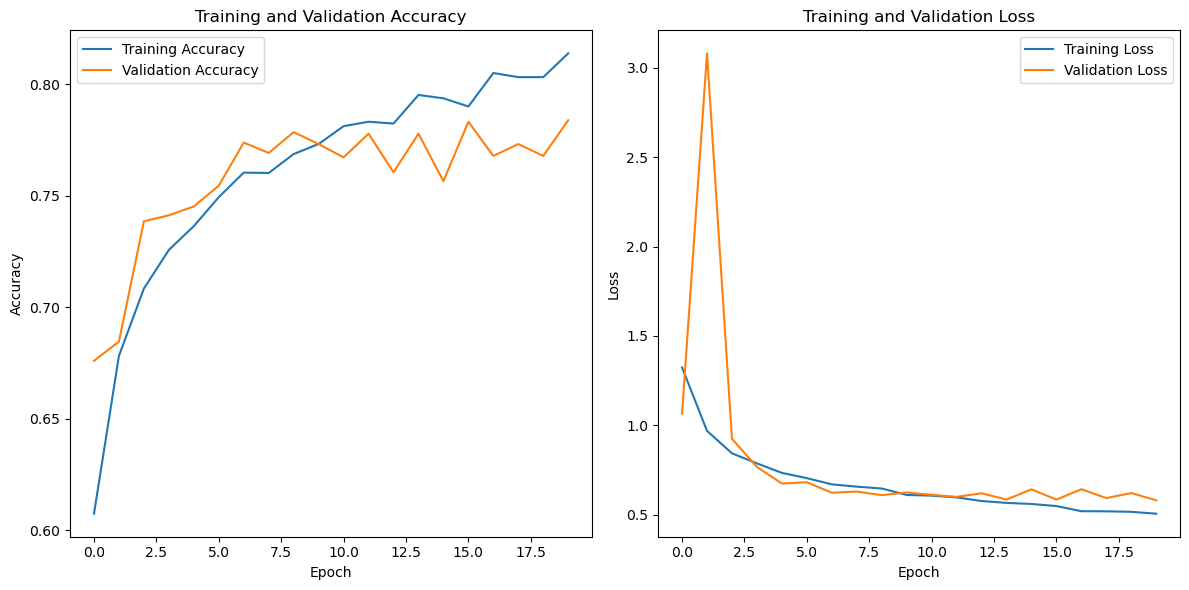

In [96]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(tl_history.history['accuracy'], label='Training Accuracy')
plt.plot(tl_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(tl_history.history['loss'], label='Training Loss')
plt.plot(tl_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


<a id = 'testdata' ></a>

# Test data Set

In [57]:
df_test = pd.read_csv('C:/Users/filip/OneDrive/Ambiente de Trabalho/escola/Deep Learning/ProjectDL23_24/HAM10000_metadata.csv')


#join of the file path of eaxh image to the CSV
image_dir = 'C:\\Users\\filip\\OneDrive\\Ambiente de Trabalho\\escola\\Deep Learning\\ProjectDL23_24\\test'
#image_dir = '/Users/hugobarata/Desktop/ProjectDL23_24/train'

df_test['path'] = df_test['image_id'].apply(lambda image_id: os.path.join(image_dir, f'{image_id}.jpg'))
df_test.head(5)


,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\filip\OneDrive\Ambiente de Trabalho\e...


In [59]:
num_rows_test = df_test.shape[0]
print("Number of rows in df_test:", num_rows_test)


Number of rows in df_test: 10015


In [60]:
# Filter the DataFrame to include only rows with existing image files
df_test = df_test[df_test['image_id'].apply(image_exists)]
num_rows_test = df_test.shape[0]
print("Number of rows in df_test:", num_rows_test)

Number of rows in df_test: 2504


In [61]:
df_test['image'] = df_test['path'].map(lambda x: np.asarray(Image.open(x).resize((50,50)))) 


In [62]:
images = np.array(df_test['image'].tolist())  

# Convert the list of images to a NumPy array
images = np.array(images)

# Normalize pixel values to be between 0 and 1
images = images / 255.0

In [63]:
label_encoder = LabelEncoder()
df_test['numeric_labels'] = label_encoder.fit_transform(df_test['dx'])

# One-hot encode the numeric labels
labels = to_categorical(df_test['numeric_labels'])

<a id = 'predicttest' ></a>

# Predicting Test with DenseNet121

In [97]:
#Predicting test with DenseNet121
predictions = tl_model.predict(images)
print(predictions)

79/79 [==============================] - 10s 93ms/step
[[3.84529859e-01 2.83599794e-01 2.73862898e-01 ... 3.07969544e-02
  1.75082013e-02 9.21750965e-04]
 [3.27972346e-03 2.08095624e-03 7.42748156e-02 ... 1.73803642e-01
  7.43839145e-01 9.53960873e-04]
 [4.42017093e-02 1.60509103e-03 7.95448184e-01 ... 1.48455679e-01
  1.02213565e-02 1.00937832e-05]
 ...
 [2.59551615e-01 7.93294888e-03 1.78961426e-01 ... 1.23258755e-01
  4.28388357e-01 1.29359963e-04]
 [4.14287090e-01 5.18809855e-01 4.65076454e-02 ... 6.14997745e-03
  2.92321621e-03 4.32817760e-04]
 [2.46935293e-01 6.04509354e-01 1.00549661e-01 ... 1.86987277e-02
  1.26309199e-02 9.83527512e-04]]


In [98]:
from sklearn.metrics import accuracy_score, f1_score

# Convert  to class labels
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Convert one-hot encoded true labels to class labels
true_labels = label_encoder.inverse_transform(labels.argmax(axis=1))

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1 Score: {f1}')


Accuracy: 0.7887380191693291
F1 Score: 0.780205805399293


<a id = 'predicttestfinal' ></a>

# Predicting test with the final model

In [89]:

predictions = model_2.predict(images)


NameError: name 'model_2' is not defined

In [68]:
#Convert the predicted probabilities to class labels
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Convert one-hot encoded true labels to class labels
true_labels = label_encoder.inverse_transform(labels.argmax(axis=1))

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1 Score: {f1}')


Accuracy: 0.7615814696485623
F1 Score: 0.7455364698994108


# Test Evaluation

In [69]:
# Add predicions  to df_test
df_test['predicted_label'] = predicted_labels

In [70]:
# Plotting Accuracy and F1 
true_labels = df_test['dx']
predicted_labels = df_test['predicted_label']


accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1 Score: {f1}')


Accuracy: 0.7615814696485623
F1 Score: 0.7455364698994108


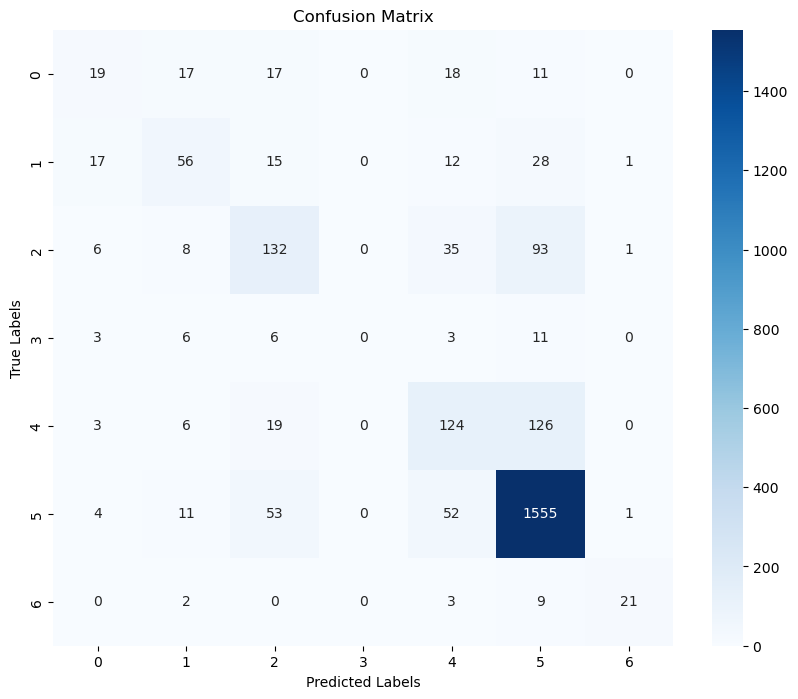

In [76]:

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix 
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Cases where true label is 'bkl' and predicted label is 'bkl':


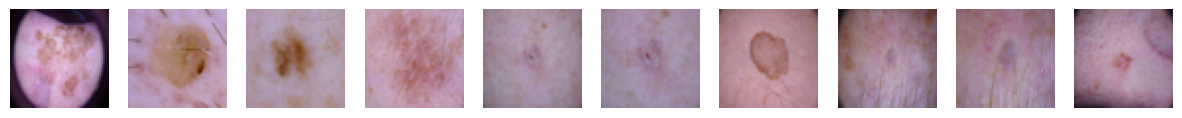


Cases where true label is 'df' and predicted label is 'df':


<Figure size 1500x500 with 0 Axes>


Cases where true label is 'mel' and predicted label is 'mel':


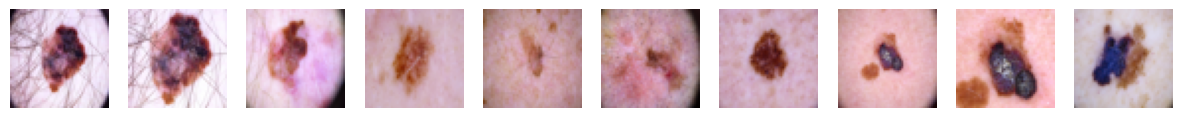


Cases where true label is 'vasc' and predicted label is 'vasc':


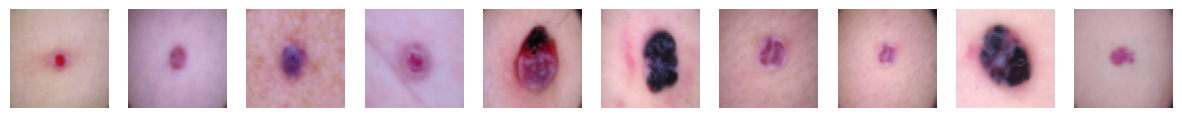


Cases where true label is 'bcc' and predicted label is 'bcc':


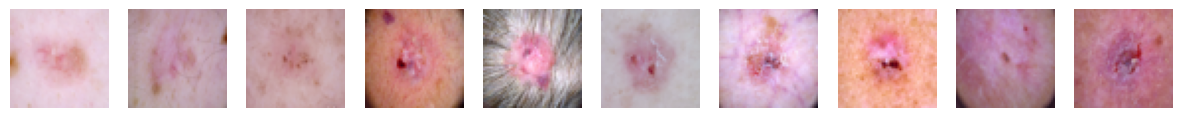


Cases where true label is 'nv' and predicted label is 'nv':


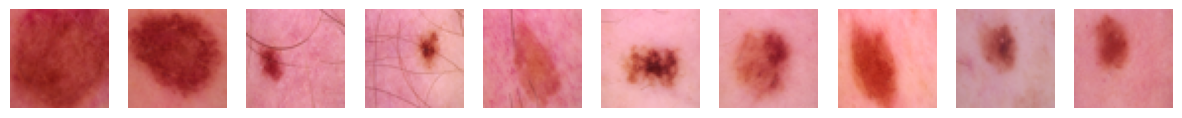


Cases where true label is 'akiec' and predicted label is 'akiec':


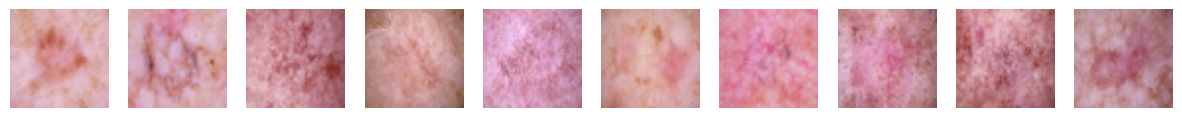

In [77]:
# Get unique cancer types in the DataFrame
unique_cancer_types = df_test['dx'].unique()

# Display 10 photos for each type of cancer
for cancer_type in unique_cancer_types:
    cancer_cases = df_test[(true_labels == cancer_type) & (predicted_labels == cancer_type)].head(10)
    
    print(f"\nCases where true label is '{cancer_type}' and predicted label is '{cancer_type}':")
    
    plt.figure(figsize=(15, 5))
    for i, (index, row) in enumerate(cancer_cases.iterrows()):
        plt.subplot(1, 10, i + 1)
        plt.imshow(row['image'])
        plt.axis('off')
    plt.show()



Cases where df_test['dx'] is 'df':


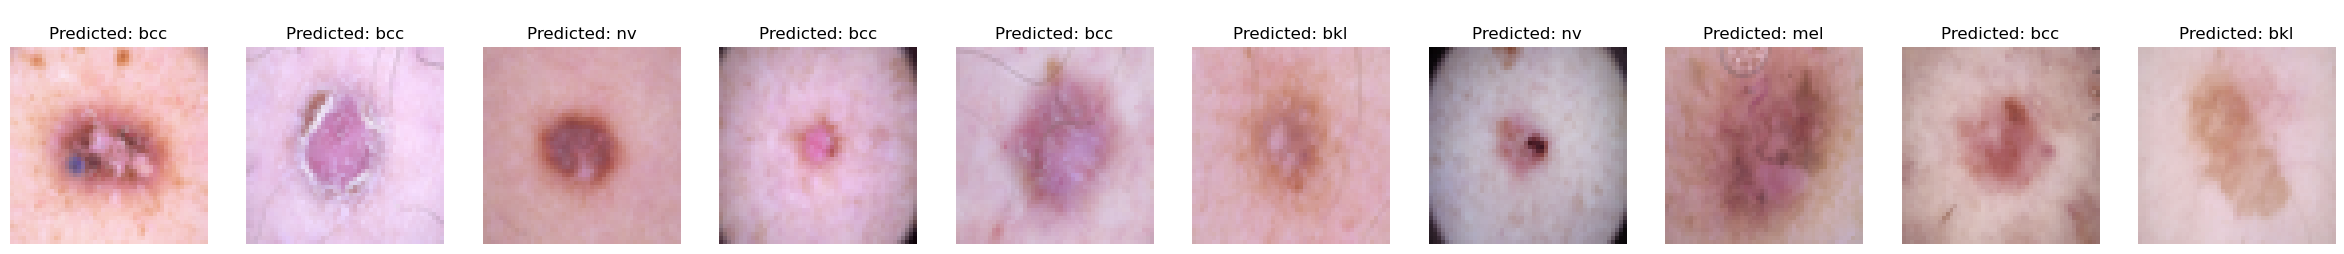

In [78]:
# Display 10 photos where our class  is equal to "df"
df_cases = df_test[df_test["dx"] == "df"].head(10)

print("\nCases where 'dx' is 'df':")

plt.figure(figsize=(30, 30))
for i, (index, row) in enumerate(df_cases.iterrows()):
    plt.subplot(1, 10, i + 1)
    plt.imshow(row['image'])
    plt.title(f'\nPredicted: {row["predicted_label"]}')
    plt.axis('off')
plt.show()



Cases where true label is 'bkl' and predicted label is 'nv':


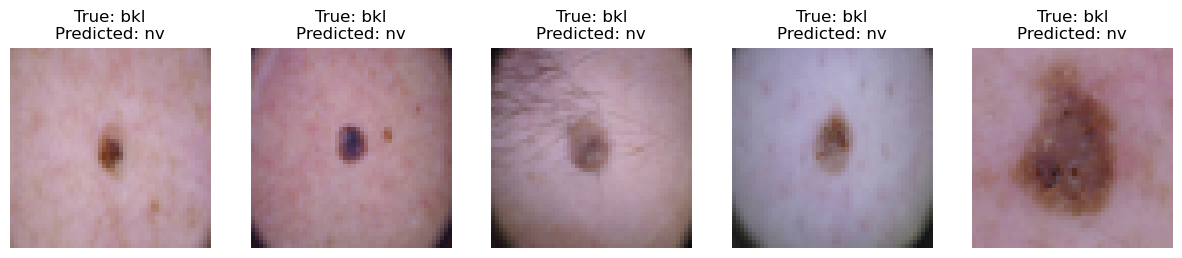

In [79]:
# Display images where true label is 'bkl' and predicted label is 'nv'
bkl_nv_cases = df_test[(true_labels == 'bkl') & (predicted_labels == 'nv')].head(5)
print("\nWhere true label is 'bkl' and predicted label is 'nv':")

plt.figure(figsize=(15, 5))
for i, (index, row) in enumerate(bkl_nv_cases.iterrows()):
    plt.subplot(1, 5, i + 1)
    plt.imshow(row['image'])
    plt.title(f'True: {row["dx"]}\nPredicted: {row["predicted_label"]}')
    plt.axis('off')
plt.show()



Cases where true label is 'mel' and predicted label is 'nv':


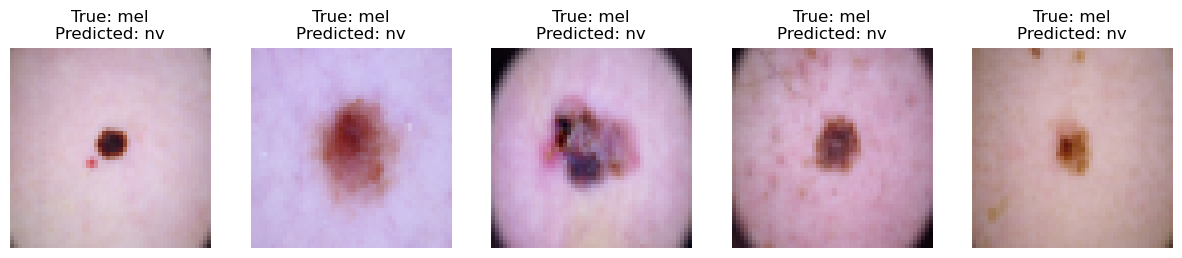

In [80]:
# Display images where true label is 'mel' and predicted label is 'nv'
mel_nv_cases = df_test[(true_labels == 'mel') & (predicted_labels == 'nv')].head(5)
print("\nCases where true label is 'mel' and predicted label is 'nv':")

plt.figure(figsize=(15, 5))
for i, (index, row) in enumerate(mel_nv_cases.iterrows()):
    plt.subplot(1, 5, i + 1)
    plt.imshow(row['image'])
    plt.title(f'True: {row["dx"]}\nPredicted: {row["predicted_label"]}')
    plt.axis('off')
plt.show()


Cases where true label is 'nv' and predicted label is 'mel':


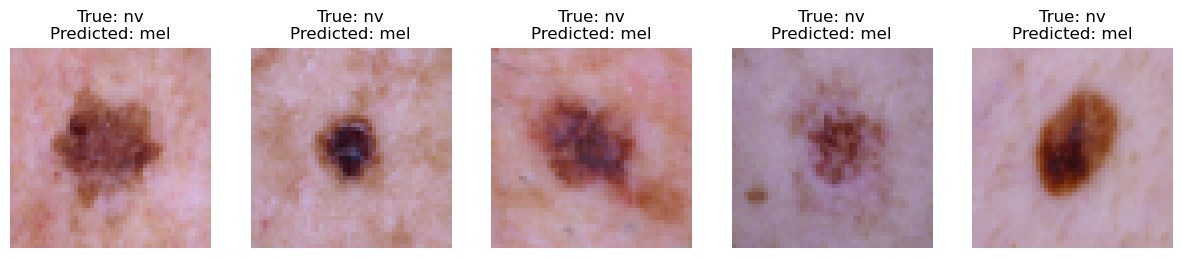

In [81]:
# Display images where true label is 'nv' and predicted label is 'mel'
nv_mel_cases = df_test[(true_labels == 'nv') & (predicted_labels == 'mel')].head(5)
print("\nCases where true label is 'nv' and predicted label is 'mel':")

plt.figure(figsize=(15, 5))
for i, (index, row) in enumerate(nv_mel_cases.iterrows()):
    plt.subplot(1, 5, i + 1)
    plt.imshow(row['image'])
    plt.title(f'True: {row["dx"]}\nPredicted: {row["predicted_label"]}')
    plt.axis('off')
plt.show()